In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

sys.path += ['../src/']

In [3]:
from pathlib import Path

import cv2
import numpy as np
from PIL import Image

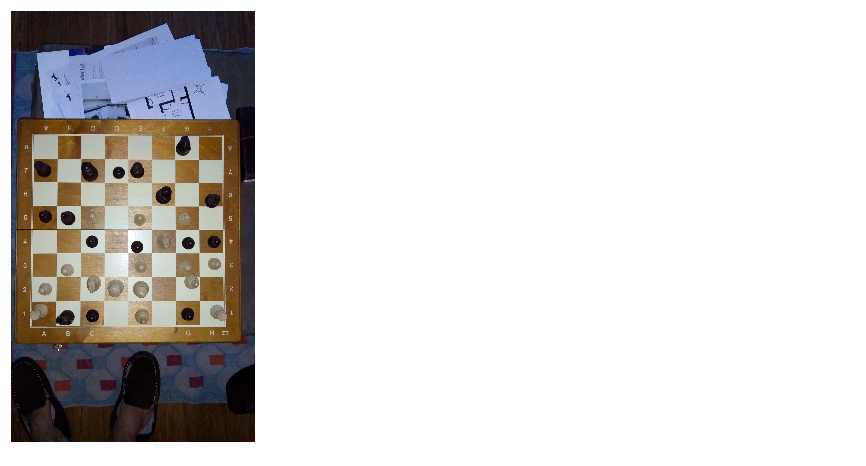

In [4]:
from itertools import chain  

FAIL_BOARD = '../data/raw/RandomLinesFails.jpg'
board_image = Image.open(FAIL_BOARD, 'r')

def show(*pil_images, n_img_per_row=3, figsize=(12, 6)):    
    n_images = len(pil_images)

    fig, axe_matrix = plt.subplots(1 + n_images // n_img_per_row, n_img_per_row, squeeze=False)
    fig.set_size_inches(figsize)

    for i, pil_image in enumerate(pil_images):
        row, col = (i // n_img_per_row), i % n_img_per_row
        ax = axe_matrix[row, col]
        ax.imshow(np.asarray(pil_image))#, aspect='auto')
        ax.set_xticks([]); ax.set_yticks([]);

    for ax in chain.from_iterable(axe_matrix):
        ax.set_axis_off()
    fig.subplots_adjust(left=.001, bottom=.001, right=.999, top=.999, wspace=.001, hspace=.001)

show(board_image)

In [305]:
from chessid import detection
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3264, 1840, 3)
0.01862928255541347


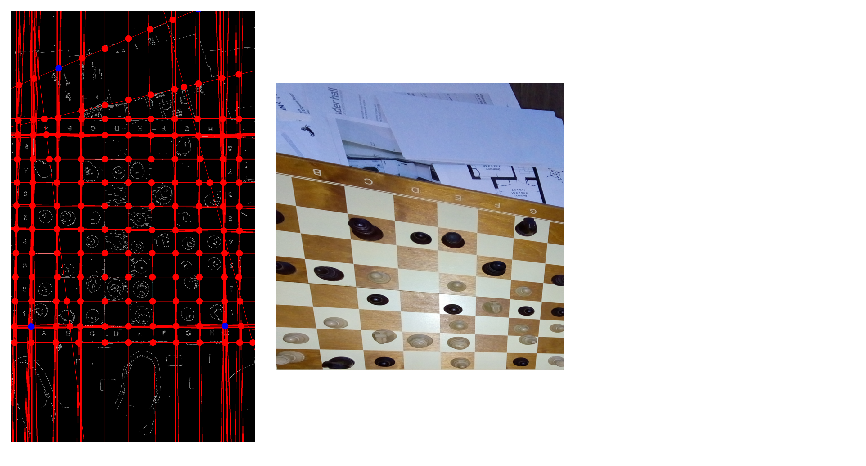

In [306]:
with Path(FAIL_BOARD).open('rb') as f:
    image = np.asarray(bytearray(f.read()))

result = detection.find_board(image)

show(result.debug, result.board)

In [128]:
from scipy import spatial

def only_inside_points(output_points, output_square_size, epsilon=1):
    inside_mask = np.logical_and(
        output_points >= -epsilon,
        output_points <= (8*output_square_size+epsilon)
    ).all(axis=1)
    return output_points[inside_mask, :]


def ideal_output_points(output_square_size):
    grid = np.linspace(start=0, stop=output_square_size * 8, num=8+1)
    return [(x, y) for x in grid for y in grid]


def closest_points_to_ideal_distances(points, output_square_size):
    ideal_points = ideal_output_points(output_square_size)
    real_to_ideal_distances = spatial.distance.cdist(points, ideal_points, 'euclidean')
    return real_to_ideal_distances


def show_points(points, *args, with_grid=False, **kwargs):
    x, y = zip(*points)
    plt.plot(x, -np.array(y), *args, **kwargs)
    if with_grid:
        plt.vlines(x=(0, 8*100), ymin=-800, ymax=0, colors='grey')
        plt.hlines(y=(0, -8*100), xmin=0, xmax=800, colors='grey')
    plt.xticks([]);plt.yticks([])

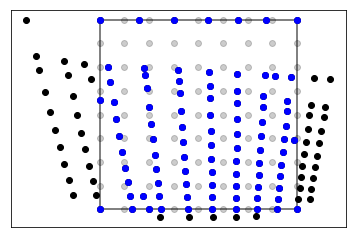

In [129]:
output_square_size = 100
output_points = detection.perspective_transform(result.corner_points, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [130]:
distances.shape

(85, 81)

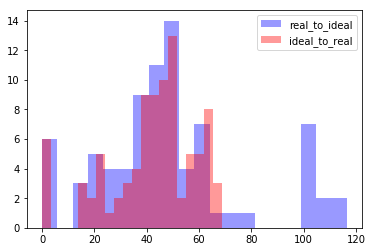

In [131]:
inside_points = only_inside_points(output_points, output_square_size)
distances = closest_points_to_ideal_distances(inside_points, output_square_size)

plt.hist(distances.min(axis=0), bins=20, color='blue', label='real_to_ideal', alpha=.4);
plt.hist(distances.min(axis=1), bins=20, color='red', label='ideal_to_real', alpha=.4);
plt.legend();

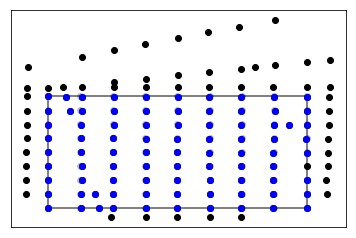

In [132]:
better_corners = [
 (167, 941),
 (152.79538, 2392.0168),
 (1614.2286, 2389.4658),
 (1596, 947)]

output_points = detection.perspective_transform(better_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

(85, 81)
(81,)


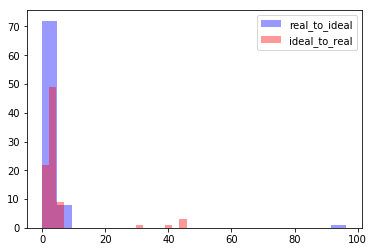

In [133]:
inside_points = only_inside_points(output_points, output_square_size)

distances = closest_points_to_ideal_distances(inside_points, output_square_size)

print(distances.shape)
print(distances.min(axis=0).shape)

plt.hist(distances.min(axis=0), bins=20, color='blue', label='real_to_ideal', alpha=.4);
plt.hist(distances.min(axis=1), bins=20, color='red', label='ideal_to_real', alpha=.4);
plt.legend();

## Stopping criterion

In [296]:
def mixed_distance(candidate_corner_points, all_points, output_square_size=100):
    output_points = detection.perspective_transform(candidate_corner_points, all_points, output_square_size)
    inside_points = only_inside_points(output_points, output_square_size)
    distances = closest_points_to_ideal_distances(inside_points, output_square_size)
    
    n_points = inside_points.shape[0]
        
    return np.mean(distances.min(axis=1)) + np.median(distances.min(axis=0)) + (n_points - 81) * (n_points - 81)


all_points = np.array(result.all_points, dtype=np.float32)
x_min, y_min = all_points.min(axis=0)
x_max, y_max = all_points.max(axis=0)

# initial candidates
max_corner_points = np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]])
closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)

candidate_corner_points = all_points[closest_points_distances.argmin(axis=1), :]

print(mixed_distance(candidate_corner_points, all_points, output_square_size))
print(mixed_distance(better_corners, all_points, output_square_size))

168.30861950947562
24.59884028859595


In [105]:
% timeit median_distance(candidate_corner_points, all_points, output_square_size)

263 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [141]:
from itertools import product


def topn_closest_to_corners_indexes(max_corner_points, all_points, topn=10):
    closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)
    topn_closest_to_corners_indexes = np.argpartition(closest_points_distances, kth=topn, axis=1)[:, :topn]

    return (
        all_points[indexes, :]
        for indexes in product(*topn_closest_to_corners_indexes) 
        if len(set(indexes)) == 4)

candidate_corners = topn_closest_to_corners_indexes(max_corner_points, all_points, topn=5)

len(list(candidate_corners))

625

In [142]:
candidate_and_criteria = [
    (corners, mixed_distance(corners, all_points, output_square_size))
    for corners in topn_closest_to_corners_indexes(max_corner_points, all_points, topn=10)]

In [143]:
candidates, criteria = zip(*candidate_and_criteria)

print(min(criteria))

25.326252874906476


In [144]:
best_corners, criterium = candidate_and_criteria[np.argmin(criteria)]

criterium

25.326252874906476

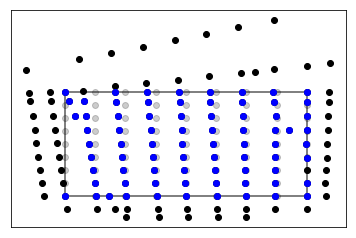

In [297]:
output_points = detection.perspective_transform(best_corners, result.all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

In [298]:
topn=15
closest_points_distances = spatial.distance.cdist(max_corner_points, all_points)
topn_closest_to_corners_indexes = np.argpartition(closest_points_distances, kth=topn, axis=1)[:, :topn]

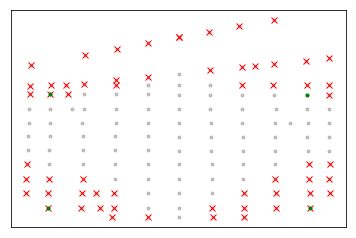

In [299]:
show_points(all_points, '.k', alpha=.2)

for indexes in topn_closest_to_corners_indexes:
    show_points(all_points[indexes], 'xr')

show_points(better_corners, 'og', ms=3)


[[1467.05764909  894.53775384]
 [1924.79060013 1195.99632064]
 [ 980.76738042  857.66098647]
 [1144.86776237 2195.66400681]]
117.91582732544428


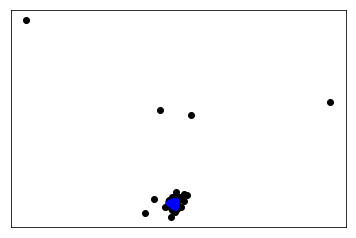

In [314]:
from functools import partial
from scipy import optimize

optim_result = optimize.basinhopping(
    lambda coordinates:mixed_distance(coordinates.reshape((-1, 2)), all_points),
    x0=all_points[np.random.choice(len(all_points), 4)].ravel(),
    niter=25, T=1.0, stepsize=10, minimizer_kwargs={'method':'Nelder-Mead'}
)

print(optim_result.x.reshape((-1, 2)))
print(optim_result.fun)
output_points = detection.perspective_transform(optim_result.x.reshape((-1, 2)), all_points, output_square_size)

show_points(ideal_output_points(output_square_size), 'ok', alpha=.2, with_grid=True)
show_points(output_points, 'ok', with_grid=True)
show_points(only_inside_points(output_points, output_square_size), 'ob', with_grid=True)

## Using lines

In [368]:
result.h_lines[:10]

[[1660.0, 1.5707964],
 [1837.0, 1.5707964],
 [2389.0, 1.5707964],
 [2385.0, 1.5707964],
 [2394.0, 1.5707964],
 [1657.0, 1.5707964],
 [2018.0, 1.5707964],
 [941.0, 1.5707964],
 [943.0, 1.5707964],
 [946.0, 1.5707964]]

In [332]:
l = result.h_lines[1]

np.abs(np.cos(l[1]) * all_points[:, 0] + np.sin(l[1]) * all_points[:, 1] - l[0]) < 0.000001

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

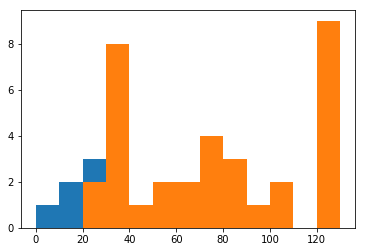

In [402]:
def line_points_intersections(lines, points):
    lines, points = np.asarray(lines), np.asarray(points) 
    cos_thetas_x = np.dot(np.cos(lines)[:, [1]], points[:, [0]].T)
    sin_thetas_y = np.dot(np.sin(lines)[:, [1]], points[:, [1]].T)
    b = np.array(lines)[:, [0]]
    return (cos_thetas_x + sin_thetas_y - b < 0.000001)

intersections = line_points_intersections(result.h_lines, result.all_points)

n_intersections_lines = intersections.sum(axis=1)

selected_mask = n_intersections_lines > 20
selected_h_lines = np.asarray(result.h_lines)[selected_mask]

plt.hist(n_intersections_lines, bins=range(0, 140, 10));
plt.hist(n_intersections_lines[selected_mask], bins=range(0, 140, 10));

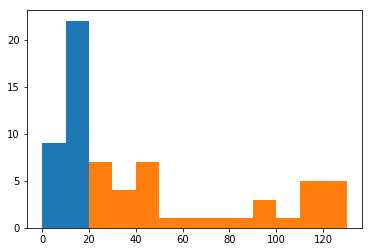

In [400]:
intersections = line_points_intersections(result.v_lines, result.all_points)

n_intersections_lines = intersections.sum(axis=1)
selected_mask = n_intersections_lines > 20
selected_v_lines = np.asarray(result.v_lines)[selected_mask]

plt.hist(n_intersections_lines, bins=range(0, 140, 10));
plt.hist(n_intersections_lines[selected_mask], bins=range(0, 140, 10));

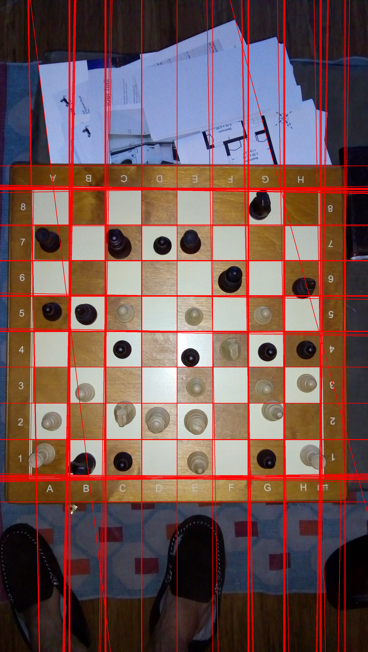

In [404]:
detection.cv_to_pil(
    detection.draw_lines(detection.cv2.imdecode(image, 1), np.concatenate([selected_v_lines, selected_h_lines])), ratio=.2)

41
13
70
26


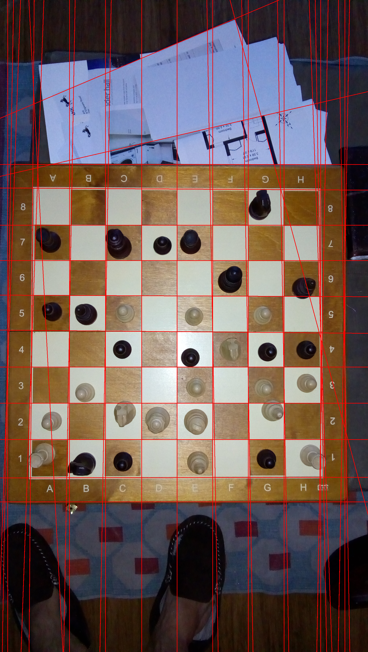

In [413]:
selected_h_lines = detection.cluster(result.h_lines, max_dist=20)
selected_v_lines = detection.cluster(result.v_lines, max_dist=20)

print(len(result.h_lines))
print(len(selected_h_lines))

print(len(result.v_lines))
print(len(selected_v_lines))


detection.cv_to_pil(
    detection.draw_lines(detection.cv2.imdecode(image, 1), np.concatenate([
        selected_h_lines, selected_v_lines])), ratio=.2)

In [415]:
selected_h_lines

[(1652.5, 1.579523),
 (1837.0, 1.5707964),
 (2392.1, 1.5690509),
 (2018.0, 1.5707964),
 (940.8889, 1.576614),
 (2200.0, 1.5707964),
 (1127.5, 1.5707964),
 (1304.5, 1.5707964),
 (1477.5, 1.5751597),
 (823.0, 1.5707964),
 (545.0, 1.1693705),
 (860.0, 1.3439035),
 (2512.0, 1.5707964)]

In [416]:
selected_v_lines

[(885.0, 0.0),
 (171.09091, 0.007933315),
 (1063.0, 0.0),
 (67.25, 0.017453292),
 (-1576.0, 3.1241393),
 (-143.66667, 3.0892327),
 (1724.0, 0.0),
 (708.0, 0.0),
 (1603.0, 0.0),
 (1241.0, 0.0),
 (527.0, 0.0),
 (1420.6666, 0.0),
 (375.75, 0.017453292),
 (38.0, 0.0),
 (347.0, 0.0),
 (-1692.0, 3.1241393),
 (-1387.0, 3.1241393),
 (219.0, 0.034906585),
 (556.0, 0.017453292),
 (-1545.0, 3.1066864),
 (1640.5, 0.017453292),
 (-1208.0, 3.1241393),
 (102.0, 0.034906585),
 (-1111.0, 2.8797932),
 (1748.0, 0.017453292),
 (-1034.0, 3.1241393)]